In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
import sys
DIR = Path(".").absolute()
sys.path.append(str(DIR.parent))
print(sys.path[0])

OUT = DIR / "data-tuning-tmp"
list(OUT.iterdir())

/home/sieverts/miniconda3/envs/finetune/lib/python311.zip


[PosixPath('/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning-tmp/dampersearch')]

In [2]:
import pickle
from typing import Any
import json
import pandas as pd
import numpy as np

from single import Wrapper, MLP

def _serialize(x: Any) -> Any:
    if isinstance(x, np.float64):
        return float(x)
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {k: _serialize(v) for k, v in x.items()}
    if isinstance(x, list):
        return [_serialize(v) for v in x]
    return x

def get_damper(damper: str) -> pd.DataFrame:
    with open(OUT / f"search-{damper}.pkl", "rb") as f:
        search = pickle.load(f)
    df = pd.DataFrame(search.cv_results_)
    df = df.sort_values(by="mean_test_score", ascending=False)
    return df

DAMPERS = ["sgd", "gd", "adagrad", "geodamp", "adadampnn", "geodamplr"]
dfs = [get_damper(d) for d in DAMPERS]
df = pd.concat(dfs).reset_index()

print(df.columns)
best_idx =  df.groupby("param_damper")["mean_test_score"].idxmax().to_numpy()
print(best_idx)
__params = df.loc[best_idx]["params"].to_list()
_params = _serialize(__params)
assert len(_params) == len(__params)
from pprint import pprint
_params2 = {p["damper"]: p for p in _params}
params = pd.DataFrame(_params)
# with open("tuned-params-2025-01-02.json", "w") as f:
#     json.dump(_params2, f)
params

/home/sieverts/Developer/adadamp-experiments/exp-finetune/train.py


FileNotFoundError: [Errno 2] No such file or directory: '/home/sieverts/Developer/adadamp-experiments/exp-finetune/data-tuning-tmp/search-sgd.pkl'

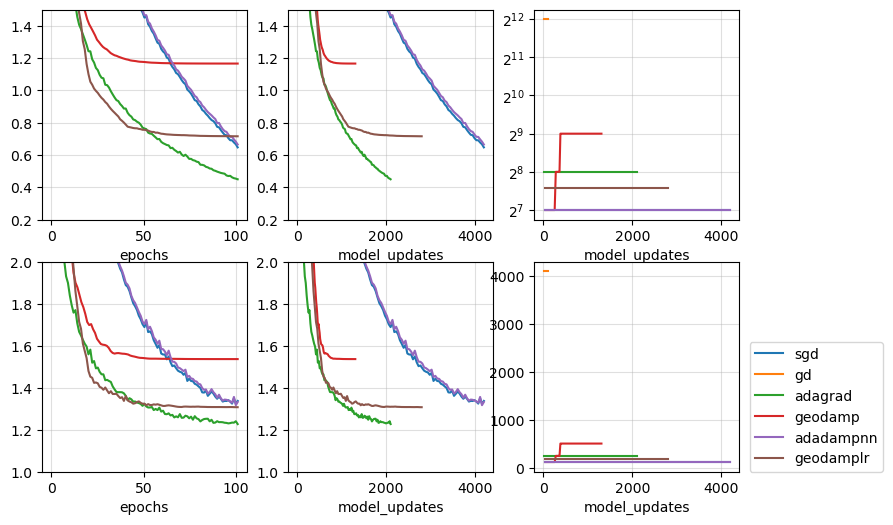

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def get_searches(damper: str) -> pd.DataFrame:
    with open(OUT / f"search-{damper}.pkl", "rb") as f:
        search = pickle.load(f)
    return search.best_estimator_

ests = [get_searches(d) for d in DAMPERS]

w = 3
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3 * w, 2 * w))
for name, est in zip(DAMPERS, ests):
    _df = pd.DataFrame(est.data_)
    _df["num_examples"] /= 10e3
    _df.plot(x="epochs", y="train_loss", ax=axs[0][0], label=name)
    kwargs = dict(label=None)
    _df.plot(x="model_updates", y="train_loss", ax=axs[0][1], **kwargs)
    _df.plot(x="model_updates", y="batch_size_", ax=axs[0][2], **kwargs)
    _df.plot(x="epochs", y="test_loss", ax=axs[1][0], **kwargs)
    _df.plot(x="model_updates", y="test_loss", ax=axs[1][1], **kwargs)
    _df.plot(x="model_updates", y="batch_size_", ax=axs[1][2], label=name)

axs[0][2].set_yscale("log", base=2)
axs[1][2].legend(loc=(1.05, 0))

# axs[0][0].set_xlim(0, 4)
# axs[1][0].set_xlim(0, 4)
# axs[0][1].set_xlim(0, 2000)
# axs[1][1].set_xlim(0, 2000)

for i, row in enumerate(axs):
    for k, ax in enumerate(row):
        if i != 1 or k != 2:
            ax.legend_.remove()
        ax.grid(alpha=0.4)
        if i == 1 and k <= 1:
            ax.set_ylim(1, 2)
        if i == 0 and k <= 1:
            ax.set_ylim(0.2, 1.5)

Figure 1:

- works in theory
- {adaptive, static} x {batch size, learning rate}


Figure 2:

- AdaDamp works with complex models.
- RadaDamp works in practice.

Figure 3:

- 

In [8]:
df.pivot_table(
    columns="param_damper",
    values="mean_test_score",
    aggfunc="max",
)

param_damper,adadampnn,adagrad,gd,geodamp,geodamplr,sgd
mean_test_score,-1.348023,-1.252983,-2.398532,-1.561781,-1.334058,-1.346386


In [9]:
df.columns

Index(['index', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_damper', 'param_dwell',
       'param_initial_batch_size', 'param_lr', 'param_max_batch_size',
       'param_momentum', 'param_nesterov', 'param_weight_decay', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'param_dampingdelay', 'param_dampingfactor'],
      dtype='object')

['dwell', 'initial_batch_size', 'lr', 'max_batch_size', 'momentum', 'nesterov', 'weight_decay']
['adadampnn' 'adagrad' 'gd' 'geodamp' 'geodamplr' 'sgd']


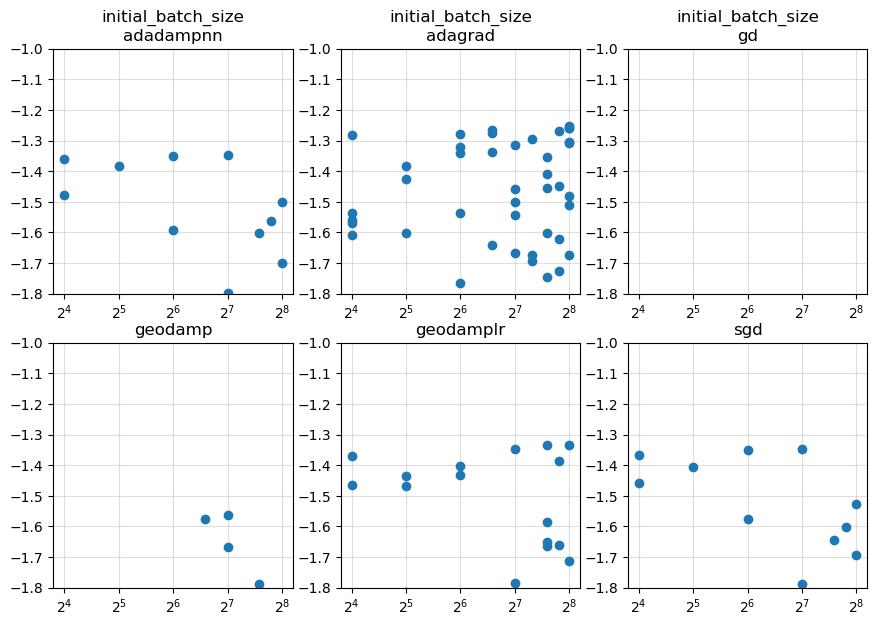

In [10]:
import matplotlib.pyplot as plt

w = 3.5
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3 * w, 2 * w))

param_names = [c for c in params.columns if "damper" not in c and "damping" not in c]
dampers = params.damper.unique()
print(param_names)
param = "max_batch_size"
param = "initial_batch_size"
print(dampers)
for k, (damper, ax) in enumerate(zip(dampers, axs.flatten())):
    s = df[df[f"param_damper"] == damper].copy()
    if "momentum" in param:
        s[f"param_{param}"] = 1 -s[f"param_{param}"]
    
    s.plot(x=f"param_{param}", y="mean_test_score", ax=ax, style="o")
    ax.set_xlabel("")
    ax.legend_.remove()
    if "batch_size" in param:
        ax.set_xscale("log", base=2)
    if "lr" in param or "dwell" in param or "momentum" in param:
        ax.set_xscale("log", base=10)
    if k <= 2:
        ax.set_title(f"{param}\n{damper}")
    else:
        ax.set_title(damper)
    ax.set_ylim(-1.8, -1.0)
    ax.grid(alpha=0.4)
        
    # ax.plot(

lr: pick from max scores.

SGD:
GD:
AdaGrad:
GeoDamp:
AdaDamp:

Index(['index', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_damper', 'param_dwell',
       'param_initial_batch_size', 'param_lr', 'param_max_batch_size',
       'param_momentum', 'param_nesterov', 'param_weight_decay', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'param_dampingdelay', 'param_dampingfactor'],
      dtype='object')
['param_dwell', 'param_initial_batch_size', 'param_lr', 'param_max_batch_size', 'param_momentum', 'param_weight_decay', 'param_dampingdelay', 'param_dampingfactor']


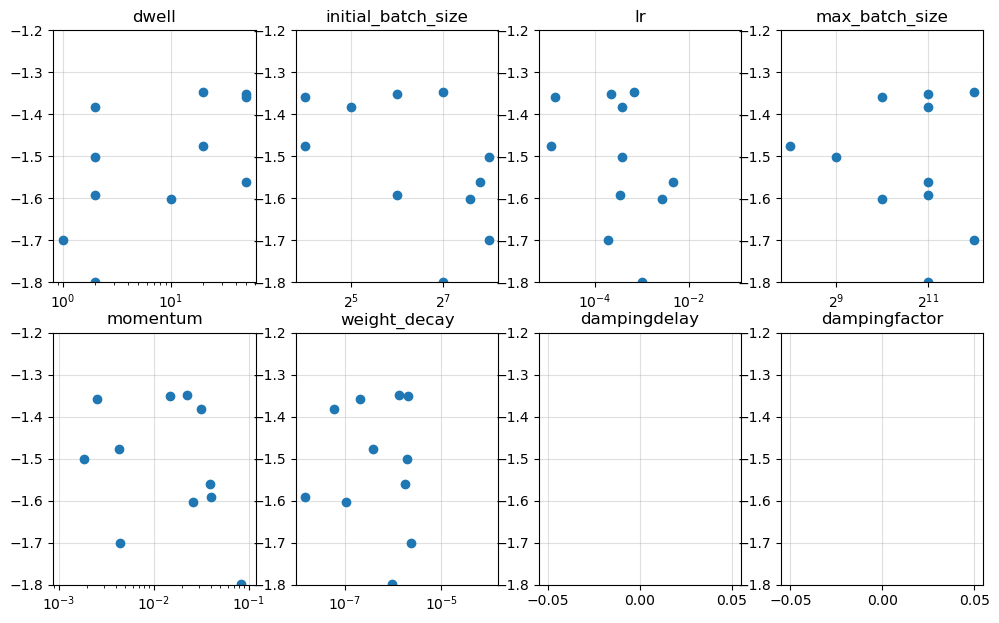

In [11]:

show = df[df.param_damper == "adadampnn"].copy()
show["param_momentum"] = 1 - show["param_momentum"]
print(show.columns)

params = [c for c in show.columns if "param_" in c and ("damper" not in c and "nesterov" not in c)]
print(params)
import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(4 * w, 2.4 * w))
for ax, param in zip(axs.flatten(), params):
    ax = show.plot(x=param, y="mean_test_score", ax=ax, style="o")
    ax.legend_.remove()
    ax.set_title(param.replace("param_", ""))
    ax.set_ylim(-2.5, None)
    ax.set_xlabel("")
    name = param.replace("param_", "")
    if name in ["dwell", "lr", "weight_decay", "momentum"]:
        ax.set_xscale("log", base=10)
    if "batch_size" in name:
        ax.set_xscale("log", base=2)
    ax.grid(alpha=0.4)
    ax.set_ylim(-1.8, -1.2)

SGD:

- dwell, momentum, mbs: not important
- ibs: not important
- lr: <= 1e-3.

GeoDamp:

- `max_batch_size`: max: 1024, initial: 16.
- dwell: 10.
- lr: 0.01.
- weight_decay: 1e-6.
- momentum: 0.9.

 'geodamp': {'damper': 'geodamp',
             'dampingdelay': 8,
             'dampingfactor': 11,
             'dwell': 10,
             'initial_batch_size': 16,
             'lr': 0.007693632621659017,
             'max_batch_size': 1024,
             'momentum': 0.9016741222295945,
             'nesterov': True,
             'weight_decay': 8.020503059027802e-07},

AdaGrad:

- lr: 0.004070  (4.07e-3)

In [34]:
df["param_max_batch_size"]

15      8192
37      None
31      1024
33      2048
34      2048
       ...  
195    16384
196     None
197      256
198     4096
199     4096
Name: param_max_batch_size, Length: 200, dtype: object

In [7]:
import pickle
import random
import torch
import train

model_f = random.choice(list(OUT.glob("model-*")))
ident = model_f.name.split("-")[-1][:-3]
damper = model_f.name.split("-")[-2]

with open(OUT / f"stats-{damper}-{ident}.pkl", "rb") as f:
    d = pickle.load(f)
assert {
    "data_test", "data_train", "test_set", "params", "ident_", "stats_"
}.issubset(set(d.keys()))

data_train = d["data_train"]
data_test = d["data_test"]
test_set = d["test_set"]

model = train.Autoencoder(32, 100, num_input_channels=3)
model.load_state_dict(torch.load(model_f, weights_only=True))#, map_location=torch.device("cpu"))

IndexError: Cannot choose from an empty sequence

In [49]:
n_params = sum([x.numel() for x in model.parameters()])
print(n_params / 1e3)

410.855


In [50]:
import pandas as pd
df_train = pd.DataFrame(data_train)
df = pd.DataFrame(data_test)
df.head()

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,test_prefix,_epochs,_num_examples,_train_time,damping,_step_time,time,step_time,lr_,batch_size_
0,1.725050e+09,192,2048,0.01,1,3,0.000000,True,0.000348,False,...,test,1.0,58752.0,24.795258,NaN,NaN,NaN,NaN,NaN,NaN
1,1.725050e+09,192,2048,0.01,1,3,1.002508,True,0.000348,False,...,test,1.0,58752.0,22.437713,192.0,0.073229,1.725050e+09,0.073295,0.000348,192.0
2,1.725050e+09,192,2048,0.01,1,3,2.005017,True,0.000348,False,...,test,NaN,NaN,NaN,192.0,0.071437,1.725050e+09,0.071502,0.000348,192.0


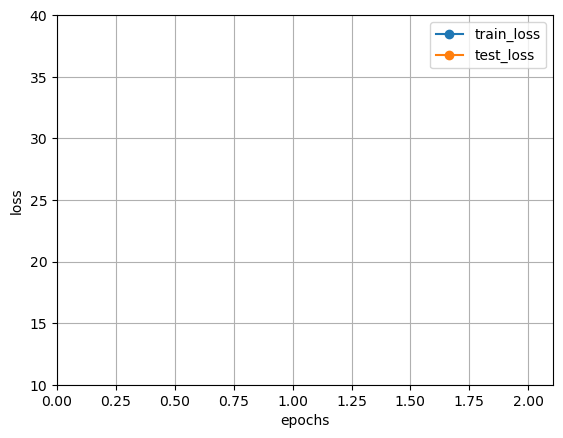

In [51]:
import matplotlib.pyplot as plt
ax = df.plot(x="epochs", y=["train_loss", "test_loss"], style="o-")
ax.set_ylim(10, 40)
ax.grid()
ax.set_ylabel("loss")
ax.set_xlim(0, None)
plt.savefig("loss.png", dpi=300, bbox_inches="tight")
# ax.set_yscale("log")

(0.0, 40.0)

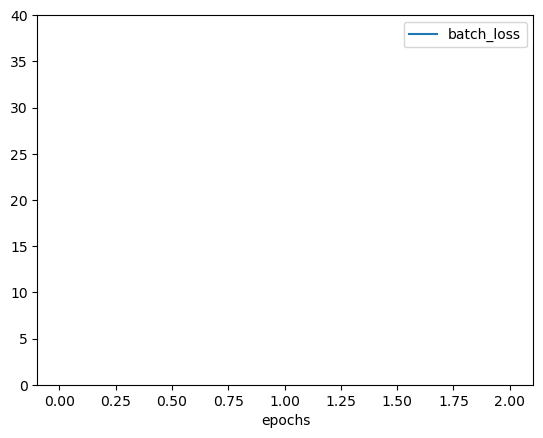

In [52]:
ax = df_train.plot(x="epochs", y="batch_loss")
ax.set_ylim(0, 40)
# ax.set_yscale("log")

In [53]:
def itransform(x, bounds=(-1, 1)):
    width = bounds[1] - bounds[0]
    offset = bounds[0]
    return (x - offset) / width

(32, 32, 3)
(32, 32, 3)
0.54509807 0.09019607
0.48877484 0.4492343
(32, 32, 3)
(32, 32, 3)
0.7254902 0.25882354
0.48877487 0.44923463
(32, 32, 3)
(32, 32, 3)
0.47450984 0.02352941
0.4887749 0.44923416
(32, 32, 3)
(32, 32, 3)
0.54901963 0.16862744
0.48877484 0.4492345
(32, 32, 3)
(32, 32, 3)
0.7411765 0.07843137
0.4887747 0.4492345


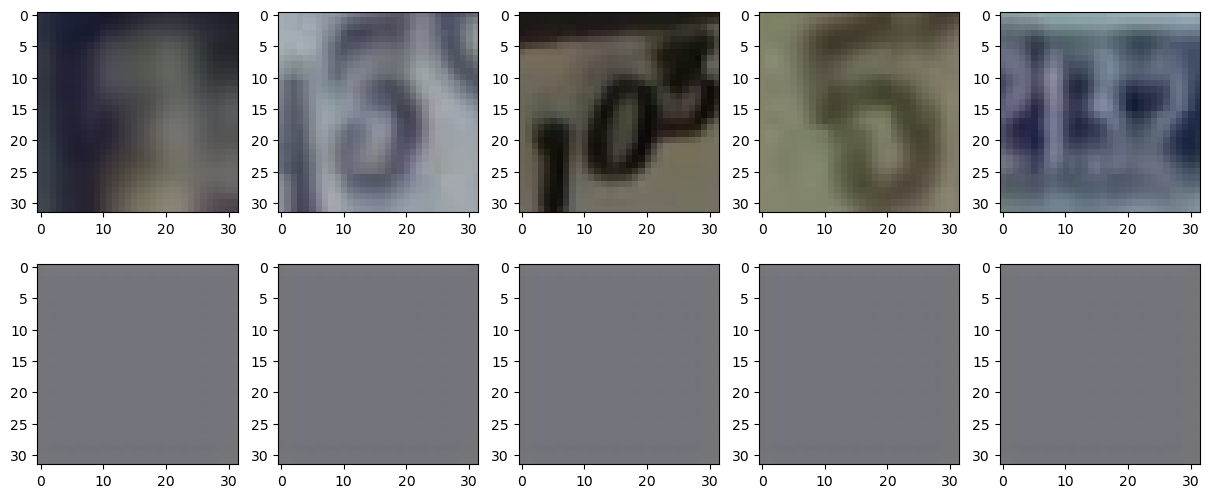

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch

w = 3
n_imgs = 5

model = model.to("cuda")
idx = np.random.choice(len(test_set), replace=False, size=n_imgs).tolist()
# idx = [2*i + 1 for i in range(n_imgs)]
imgs = [test_set[i][0] for i in idx]
imgs_in = torch.stack(imgs).to("cuda")
out = model(imgs_in).detach().cpu().numpy()

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(n_imgs * w, 2 * w))
for i in range(n_imgs):
    img = imgs[i] # [imgs[i][0], imgs[i][1], imgs[i][2]]
    oimg = out[i]
    img2 = np.stack((img[0, :, :], img[1, :, :], img[2, :, :]), axis=-1)
    out2 = np.stack((oimg[0], oimg[1], oimg[2]), axis=-1)
    img2 = itransform(img2)
    out2 = itransform(out2)
    print(img2.shape)
    print(out2.shape)
    print(img2.max(), img2.min())
    print(out2.max(), out2.min())
    axs[0][i].imshow(img2)
    axs[1][i].imshow(out2)

In [29]:
fig.savefig("./example.png", dpi=300, bbox_inches="tight")

In [34]:
!open .